In [1]:
!apt-get install swig
!pip install smac[all]

Reading package lists... Done
Building dependency tree       
Reading state information... Done
swig is already the newest version (3.0.12-1).
The following packages were automatically installed and are no longer required:
  cuda-cufft-10-1 cuda-cufft-dev-10-1 cuda-curand-10-1 cuda-curand-dev-10-1
  cuda-cusolver-10-1 cuda-cusolver-dev-10-1 cuda-cusparse-10-1
  cuda-cusparse-dev-10-1 cuda-drivers cuda-license-10-2 cuda-npp-10-1
  cuda-npp-dev-10-1 cuda-nsight-10-1 cuda-nsight-compute-10-1
  cuda-nsight-systems-10-1 cuda-nvgraph-10-1 cuda-nvgraph-dev-10-1
  cuda-nvjpeg-10-1 cuda-nvjpeg-dev-10-1 cuda-nvrtc-10-1 cuda-nvrtc-dev-10-1
  cuda-nvvp-10-1 default-jre dkms freeglut3 freeglut3-dev
  keyboard-configuration libargon2-0 libcap2 libcryptsetup12 libcublas10
  libdevmapper1.02.1 libfontenc1 libgtk2.0-0 libgtk2.0-common libidn11
  libip4tc0 libjansson4 libnvidia-cfg1-440 libnvidia-common-430
  libnvidia-common-440 libnvidia-decode-440 libnvidia-encode-440
  libnvidia-fbc1-440 libnvidia-g

## Import libraries and data

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
from sklearn import svm, datasets
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.neural_network import MLPClassifier

# Import ConfigSpace and different types of parameters
from smac.configspace import ConfigurationSpace
from ConfigSpace.hyperparameters import CategoricalHyperparameter, \
    UniformFloatHyperparameter, UniformIntegerHyperparameter
from ConfigSpace.conditions import InCondition

# Import SMAC-utilities
from smac.tae.execute_func import ExecuteTAFuncDict
from smac.scenario.scenario import Scenario
from smac.facade.smac_hpo_facade import SMAC4HPO
from smac.facade.smac_bo_facade import SMAC4BO
from smac.configspace import ConfigurationSpace, Configuration

from smac.optimizer.acquisition import LCB, EI, PI
from smac.initial_design.random_configuration_design import RandomConfigurations
from smac.runhistory.runhistory2epm import RunHistory2EPM4InvScaledCost

from numpy import genfromtxt
import logging

import matplotlib.pyplot as plt
from scipy.stats import uniform

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/php9pgo5r.csv')

df['Class'].value_counts() 

1    88
2    12
Name: Class, dtype: int64

In [6]:
df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,Class
0,-0.33,0.69,0,1,1,0,0.8,0,0.88,1
1,-0.33,0.94,1,0,1,0,0.8,1,0.31,2
2,-0.33,0.50,1,0,0,0,1.0,-1,0.50,1
3,-0.33,0.75,0,1,1,0,1.0,-1,0.38,1
4,-0.33,0.67,1,1,0,0,0.8,-1,0.50,2
...,...,...,...,...,...,...,...,...,...,...
95,-1.00,0.67,1,0,0,0,1.0,-1,0.50,1
96,-1.00,0.61,1,0,0,0,0.8,0,0.50,1
97,-1.00,0.67,1,1,1,0,1.0,-1,0.31,1
98,-1.00,0.64,1,0,1,0,1.0,0,0.19,1


In [7]:
df['V8'].value_counts()

-1    56
 0    23
 1    21
Name: V8, dtype: int64

In [8]:
df.drop('Class', axis=1).describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.078900,0.669000,0.870000,0.440000,0.510000,0.190000,0.832000,-0.350000,0.406800
std,0.796725,0.121319,0.337998,0.498888,0.502418,0.580752,0.167501,0.808728,0.186395
min,-1.000000,0.500000,0.000000,0.000000,0.000000,-1.000000,0.200000,-1.000000,0.060000
25%,-1.000000,0.560000,1.000000,0.000000,0.000000,0.000000,0.800000,-1.000000,0.250000
50%,-0.330000,0.670000,1.000000,0.000000,1.000000,0.000000,0.800000,-1.000000,0.380000
75%,1.000000,0.750000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


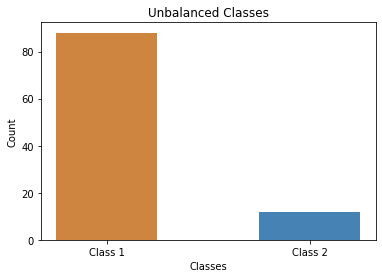

In [9]:
# Fake dataset
height = [88, 12]
bars = ('Class 1', 'Class 2')
y_pos = np.arange(len(bars))
 
# Create bars and choose color
plt.bar(y_pos, height, color=['peru','steelblue'], width=0.5)
 
# Add title and axis names
plt.title('Unbalanced Classes')
plt.xlabel('Classes')
plt.ylabel('Count')
 
# Limits for the Y axis

 
# Create names
plt.xticks(y_pos, bars)
 
# Show graphic
plt.show()



In [0]:
data_fertility = genfromtxt('/content/drive/My Drive/php9pgo5r.csv', delimiter=',', skip_header = 1)
data = data_fertility[:,:-1]
target = data_fertility[:,-1]

## Step 1

In [0]:
# Neural network 

def ann_from_cfg(cfg):

  clf = MLPClassifier(**cfg, hidden_layer_sizes = (4,2,), 
                      solver='adam', 
                      random_state=int(cfg['momentum']*cfg['learning_rate_init']*4096)) 

  SKF = StratifiedKFold(n_splits = 10, random_state = 65536)
  scores = cross_val_score(clf, data, target, cv = SKF, scoring = 'accuracy')

  return -np.mean(scores)

In [12]:
# Building Configuration Space which defines all parameters and their ranges
cs = ConfigurationSpace()
learning_rate_init = UniformFloatHyperparameter("learning_rate_init", 0.01, 0.1)
momentum = UniformFloatHyperparameter("momentum", 0.1, 0.9, default_value=0.9)
cs.add_hyperparameters([learning_rate_init,momentum])

init = cs.sample_configuration(5)

# Scenario object
scenario = Scenario({"run_obj": "quality",   # we optimize quality (alternatively runtime)
                     "runcount-limit": 25,   # max. number of function evaluations;
                     "cs": cs,               # configuration space
                     "deterministic": "true",
                     "abort_on_first_run_crash": "false"
                     })

INFO:smac.utils.io.cmd_reader.CMDReader:Output to smac3-output_2019-12-06_18:18:48_013167


In [13]:
logging.basicConfig(level=logging.INFO)  # logging.DEBUG for debug output

# Default configuration and value
def_value = ann_from_cfg(cs.get_default_configuration())

print("Configuration: ",  cs.get_default_configuration(), 
      "\nDefault Value: %.4f" % -def_value)

Configuration:  Configuration:
  learning_rate_init, Value: 0.055
  momentum, Value: 0.9
 
Default Value: 0.7730


In [0]:
# Gaussian Process (GP) as surrogate model with different aqcuisition function

def GaussianProcess_SMBO(acq_func):
  
  smac = SMAC4BO(scenario=scenario, rng=np.random.RandomState(65536),
                tae_runner=ann_from_cfg, # neural network
                initial_design=None,
                initial_design_kwargs= {'n_configs_x_params': 5, 
                                        'max_config_fracs': 5/25},  # 5 iterations for the initial configurations + 20 iterations -> 25 
                initial_configurations = init,  # the firts 5 configurations
                acquisition_function = acq_func) # SMBO: LCB or EI (in this case)
  
  incumbent = smac.optimize()
  inc_value = ann_from_cfg(incumbent)

  lr = smac.optimize()['learning_rate_init']
  m = smac.optimize()['momentum']

  results = {'lr': lr, 
              'momentum' : m,
              'score' : -inc_value
              }
  
  print("Optimized Value: %.4f" % (-inc_value))

  return smac, results

In [15]:
smac_LCB, results_LCB = GaussianProcess_SMBO(LCB) 

INFO:smac.facade.smac_bo_facade.SMAC4BO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.initial_design.InitialDesign:Running initial design for 5 configurations
INFO:smac.facade.smac_bo_facade.SMAC4BO:<class 'smac.facade.smac_bo_facade.SMAC4BO'>
INFO:smac.intensification.intensification.Intensifier:Challenger (-0.8814) is better than incumbent (-0.8714) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.06227789620451803 -> 0.03321709450764505
INFO:smac.intensification.intensification.Intensifier:  momentum : 0.21558730652235605 -> 0.62585724167987
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -0.8814
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent 

Optimized Value: 0.8914


In [16]:
smac_EI, results_EI = GaussianProcess_SMBO(EI) 

INFO:smac.facade.smac_bo_facade.SMAC4BO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.initial_design.InitialDesign:Running initial design for 5 configurations
INFO:smac.facade.smac_bo_facade.SMAC4BO:<class 'smac.facade.smac_bo_facade.SMAC4BO'>
INFO:smac.intensification.intensification.Intensifier:Challenger (-0.8814) is better than incumbent (-0.8714) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.06227789620451803 -> 0.03321709450764505
INFO:smac.intensification.intensification.Intensifier:  momentum : 0.21558730652235605 -> 0.62585724167987
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -0.8814
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent 

Optimized Value: 0.8923


In [0]:
# performance history of LCB and EI

def performance_history(smac):

  maximum = 0.00000001
  history_of_maximums = []

  history = -smac.get_X_y()[1]

  for i in range(len(history)):
      if history[i] > maximum:
          maximum = history[i]
          history_of_maximums.append(maximum)
      else:
          history_of_maximums.append(maximum) 
  
  return history_of_maximums

In [0]:
history_LCB = performance_history(smac_LCB)
history_EI = performance_history(smac_EI)

Text(0, 0.5, 'Accuracy')

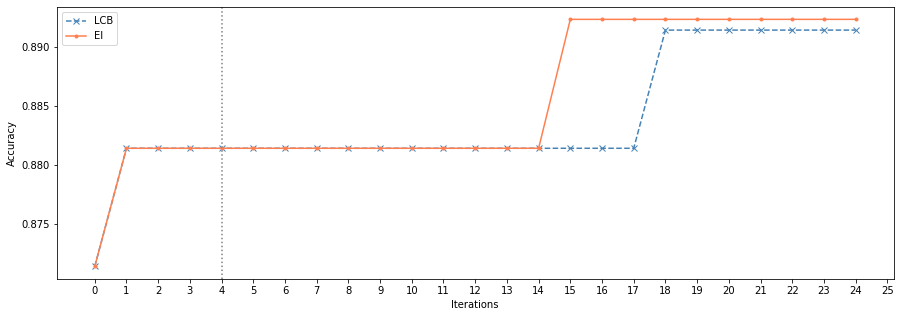

In [19]:
# Plot of the results

plt.figure(figsize = (15,5))
plt.plot(history_LCB, marker = "x", color='steelblue', linestyle='--')
plt.plot(history_EI, marker = ".", color='coral', linestyle='-')
plt.axvline(x=4, ls=':', c='grey')
plt.xticks(np.arange(0, 26, 1))

plt.legend(["LCB", "EI"])
plt.xlabel("Iterations")
plt.ylabel("Accuracy")

## Grid search

In [20]:
from sklearn.model_selection import GridSearchCV

mlp = MLPClassifier(hidden_layer_sizes = (4,2,), solver='adam')
parameter_space = {
    'momentum': [0.1,0.3,0.5,0.7,0.9],
    'learning_rate_init': [0.01,0.05, 0.075, 0.09, 0.1]
}

SKF = StratifiedKFold(n_splits = 10, random_state = 65536)
 
clf_grid = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=SKF, scoring='accuracy')
clf_grid.fit(data, target)

# Best parameter set
print('Best parameters found:\n', clf_grid.best_params_)
print('Best result:\n', clf_grid.best_score_)

Best parameters found:
 {'learning_rate_init': 0.01, 'momentum': 0.9}
Best result:
 0.88


In [0]:
results_GS = {'lr': clf_grid.best_params_['learning_rate_init'], 
              'momentum' : clf_grid.best_params_['momentum'],
              'score' : clf_grid.best_score_
              }

## Pure random search

In [22]:
from sklearn.model_selection import RandomizedSearchCV
from numpy.random import randint


parameter_space = {
    'momentum': uniform(0.1,0.9),
    'learning_rate_init': uniform(0.01,0.1)
}

n_iter_search = 25
random_search = RandomizedSearchCV(mlp, param_distributions=parameter_space,
                                   n_iter=n_iter_search, scoring= 'accuracy')

random_search.fit(data, target)

# Best paramete set
print('Best parameters found:\n', random_search.best_params_)
print('Best result:\n', random_search.best_score_)

Best parameters found:
 {'learning_rate_init': 0.03551714905768672, 'momentum': 0.9607453142292084}
Best result:
 0.88


In [0]:
results_PRS = {'lr': random_search.best_params_['learning_rate_init'], 
              'momentum' : random_search.best_params_['momentum'],
              'score' : random_search.best_score_
              }

In [0]:
lr = []
m = []
score = []

for v in results_LCB, results_EI, results_GS, results_PRS:
  lr.append(v['lr'])
  m.append(v['momentum'])
  score.append(v['score'])

results_ = {'learning rate': lr, 'momentum' : m, 'score': score}
results_ = pd.DataFrame.transpose(pd.DataFrame.from_dict(results_, 
                                                         orient='index', 
                                                         columns=['GaussianProcess_LCB','GaussianProcess_EI','GridSearch','PureRandomSearch']))

In [25]:
results_

,learning rate,momentum,score
GaussianProcess_LCB,0.047432,0.369671,0.891414
GaussianProcess_EI,0.039758,0.624561,0.892323
GridSearch,0.010000,0.900000,0.880000
PureRandomSearch,0.035517,0.960745,0.880000


## Step 2

In [0]:
def ann_from_cfg_2(cfg):

  clf_2 = MLPClassifier(learning_rate_init = cfg["learning_rate_init_2"],
                      momentum = cfg["momentum_2"], 
                      hidden_layer_sizes = (cfg["hidden_layer_1"],cfg["hidden_layer_2"],), 
                      solver='adam',
                      random_state=int(cfg['momentum_2']*cfg['learning_rate_init_2']*4096))


  SKF = StratifiedKFold(n_splits = 10, random_state = 65536)
  scores = cross_val_score(clf_2, data, target, cv = SKF, scoring = 'accuracy')


  return -np.mean(scores)

In [39]:
# Building Configuration Space which defines all parameters and their ranges
cs_2 = ConfigurationSpace()

learning_rate_init_2 = UniformFloatHyperparameter("learning_rate_init_2", 0.01, 0.1, default_value = 0.01)
momentum_2 = UniformFloatHyperparameter("momentum_2", 0.1, 0.9, default_value = 0.9)

hidden_layer_1 = UniformIntegerHyperparameter("hidden_layer_1",1,5)
hidden_layer_2 = UniformIntegerHyperparameter("hidden_layer_2",1,5)

cs_2.add_hyperparameters([learning_rate_init_2,momentum_2, hidden_layer_1, hidden_layer_2])


init_2 = cs_2.sample_configuration(10)
init_2

[Configuration:
   hidden_layer_1, Value: 2
   hidden_layer_2, Value: 2
   learning_rate_init_2, Value: 0.05396843665547687
   momentum_2, Value: 0.7351154498265777, Configuration:
   hidden_layer_1, Value: 1
   hidden_layer_2, Value: 3
   learning_rate_init_2, Value: 0.053760281004178644
   momentum_2, Value: 0.735597829427149, Configuration:
   hidden_layer_1, Value: 5
   hidden_layer_2, Value: 5
   learning_rate_init_2, Value: 0.05601397054752129
   momentum_2, Value: 0.4422735882091058, Configuration:
   hidden_layer_1, Value: 4
   hidden_layer_2, Value: 2
   learning_rate_init_2, Value: 0.04176020002237753
   momentum_2, Value: 0.29033029594977877, Configuration:
   hidden_layer_1, Value: 2
   hidden_layer_2, Value: 1
   learning_rate_init_2, Value: 0.07679063197536524
   momentum_2, Value: 0.42096373257335484, Configuration:
   hidden_layer_1, Value: 2
   hidden_layer_2, Value: 2
   learning_rate_init_2, Value: 0.018688162494101417
   momentum_2, Value: 0.619959167038195, Configu

In [40]:
# Scenario object
scenario_2 = Scenario({"run_obj": "quality",   # we optimize quality (alternatively runtime)
                     "runcount-limit": 110,   # max. number of function evaluations; for this example set to a low number
                     "cs": cs_2,               # configuration space
                     "deterministic": "true",
                     "abort_on_first_run_crash": "false"
                     })

INFO:smac.utils.io.cmd_reader.CMDReader:Output to smac3-output_2019-12-06_18:29:15_815838


In [41]:
logging.basicConfig(level=logging.INFO)  # logging.DEBUG for debug output

# It returns: Status, Cost, Runtime, Additional Infos
def_value_2 = ann_from_cfg_2(cs_2.get_default_configuration())

print(cs_2.get_default_configuration())
print("Default Value: %.4f" % -def_value_2)

Configuration:
  hidden_layer_1, Value: 3
  hidden_layer_2, Value: 3
  learning_rate_init_2, Value: 0.01
  momentum_2, Value: 0.9

Default Value: 0.8814


In [0]:
def RandomForest_SMBO_2(acq_func):
  
  smac = SMAC4HPO(scenario=scenario_2, rng=np.random.RandomState(65536),
                tae_runner=ann_from_cfg_2,
                initial_design=None,
                initial_design_kwargs= {'n_configs_x_params': 10,
                                        'max_config_fracs': 10/110}, 
                initial_configurations = init_2, 
                acquisition_function = acq_func)
  
  incumbent = smac.optimize()
  inc_value = ann_from_cfg_2(incumbent)

  lr = smac.optimize()['learning_rate_init_2']
  m = smac.optimize()['momentum_2']
  h1 = smac.optimize()['hidden_layer_1']
  h2 = smac.optimize()['hidden_layer_2']

  results = {'lr': lr, 
              'momentum' : m,
              'neurons_h1': h1,
              'neurons_h2': h2,
              'score' : -inc_value
              }
  
  print("Optimized Value: %.4f" % (-inc_value))

  return smac, results

In [43]:
smac_LCB_2, results_LCB_2 = RandomForest_SMBO_2(LCB) 

INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.initial_design.InitialDesign:Running initial design for 10 configurations
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:<class 'smac.facade.smac_hpo_facade.SMAC4HPO'>
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -0.8814
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -0.8814
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -0.8814
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -0.8814
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -0.8814
INFO:smac.intensification.intensification.Intensifier:Updated estimated

Optimized Value: 0.8914


In [44]:
smac_EI_2, results_EI_2 = RandomForest_SMBO_2(EI) 

INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.initial_design.InitialDesign:Running initial design for 10 configurations
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:<class 'smac.facade.smac_hpo_facade.SMAC4HPO'>
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -0.8814
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -0.8814
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -0.8814
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -0.8814
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -0.8814
INFO:smac.intensification.intensification.Intensifier:Updated estimated

Optimized Value: 0.8914


In [0]:
history_LCB_2 = performance_history(smac_LCB_2)
history_EI_2 = performance_history(smac_EI_2)

Text(0, 0.5, 'Accuracy')

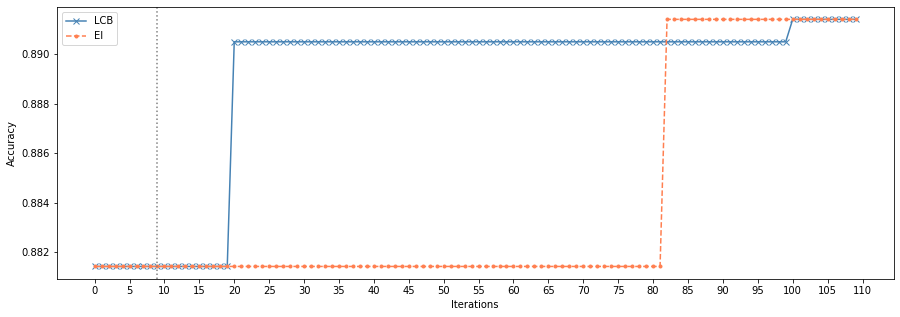

In [46]:
plt.figure(figsize = (15,5))
plt.plot(history_LCB_2, marker = "x", color='steelblue', linestyle='-')
plt.plot(history_EI_2, marker = ".", color='coral', linestyle='--')
plt.axvline(x=9, ls=':', c='grey')

plt.xticks(np.arange(0, 115, 5))

plt.legend(["LCB", "EI"])
plt.xlabel("Iterations")
plt.ylabel("Accuracy")

In [0]:
lr_2 = []
m_2 = []
h1 = []
h2 = []
score_2 = []

for v in results_LCB_2, results_EI_2:
  lr_2.append(v['lr'])
  m_2.append(v['momentum'])
  h1.append(v['neurons_h1'])
  h2.append(v['neurons_h2'])
  score_2.append(v['score'])

results_2 = {'learning rate': lr_2, 'momentum' : m_2, 'neurons_h1': h1,
            'neurons_h2': h2, 'score': score_2}
results_2 = pd.DataFrame.transpose(pd.DataFrame.from_dict(results_2, 
                                                         orient='index', 
                                                         columns=['RandomForest_LCB','RandomForest_EI']))

In [0]:
results_2['neurons_h1'] = pd.to_numeric(results_2['neurons_h1'], downcast='integer')
results_2['neurons_h2'] = pd.to_numeric(results_2['neurons_h2'], downcast='integer')

In [49]:
results_2

,learning rate,momentum,neurons_h1,neurons_h2,score
RandomForest_LCB,0.072769,0.493561,5,3,0.891414
RandomForest_EI,0.053593,0.314976,5,3,0.891414
